# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#use this cell to import additional libraries or define helper functions
from sklearn.metrics import mean_squared_error as mse

def create_predictions(ph, mu, n_s): 
    # Arrays to hold predicted values
    tp_pred = np.zeros(n_s-1) 
    yp_pred = np.zeros(n_s-1)

    # At every iteration of the for loop a new data sample is acquired
    for i in range(2, n_s+1):# start out with 2 leading datapoints
        #get x and y data "available" for our prediction
        ts_tmp = ts[0:i]
        ys_tmp = ys[0:i]
        ns = len(ys_tmp)
        
        
        weights = np.ones(ns)*mu
        for k in range(ns):
            #adjust weights to be downweighted according to their timestep away from our prediction
            weights[k] = weights[k]**k
        weights = np.flip(weights, 0)
            
        # perform linear regression on "available" data using the mu-adjusted weights
        lm_tmp = LinearRegression() 
        model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)# times are x, global active power readings are y
        # Coefficients of the linear model, y = mx + q 
        # store model coefficients and intercepts to compute prediction
        m_tmp = model_tmp.coef_
        q_tmp = model_tmp.intercept_
    
    
        #use ph to make the model prediction according to the prediction time
        tp = ts.iloc[i-1,0] + ph #next time stamp
        yp = m_tmp*tp + q_tmp #mx + b
          
        tp_pred[i-2] = tp
        # fetch the individual value so that numpy does not have deprecation warning.
        yp_pred[i-2] = yp[0][0]

    return tp_pred, yp_pred

def plot_all(tp_pred, yp_pred, mu, ph):
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
    ax.set_title('mu = %g, ph=%g ' %(mu, ph))
    ax.plot(tp_pred, yp_pred, label='Predicted Value') 
    ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
    ax.set_xlabel('time (epoch)')
    ax.set_ylabel('kilowatts')
    ax.legend()

def plot_early(tp_pred, yp_pred, mu, ph):
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle('Global Active Power Prediction - first 200', fontsize=22, fontweight='bold')
    ax.set_title('mu = %g, ph=%g ' %(mu, ph))
    ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
    ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
    ax.set_xlabel('time (epoch)')
    ax.set_ylabel('kilowatts')
    ax.legend()

def plot_late(tp_pred, yp_pred, mu, ph):
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle('Global Active Power Prediction - last 200', fontsize=22, fontweight='bold')
    ax.set_title('mu = %g, ph=%g ' %(mu, ph))
    ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
    ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
    ax.set_xlabel('time (epoch)')
    ax.set_ylabel('kilowatts')
    ax.legend()

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [3]:
#Load your data into a pandas dataframe here
df = pd.read_csv('household_power_clean.csv') 

In [4]:
#convert datetime to epoch/unix time
df['Datetime'] = pd.to_datetime(df['Datetime'])
# pandas doc recommended method https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#from-timestamps-to-epoch
df['unix'] = (df['Datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")

## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph is Prediction horizon, mu is Forgetting factor.
The Prediction horizon is the amount of time in the future we want to predict a value for. So if our ph is 5 minutes, then we are attempting to predict data for 5 minutes in the future. The forgetting factor is a value that we set to decay the data. This value basically tells our model how quickly it should "forget" historical data in order to favor newer data. 

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [5]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 300 #5 minutes 5 * 60 seconds for each second. since the timedelta is set to 1s for the epoch/unix column
ph_index = 5 #ph/data resolution (how many timesteps is our ph?) 
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:
To find the weight that the first datapoint will have on the last datapoint we can use the following formula and plug in the values:
$$
w = \mu^{(t_{\text{last}} - t_{\text{first}})}
$$
$$
w = 0.9^{(5000-1)} = 0.9^{4999}
$$
The value of w from the given equation is extremely small, meaning that the first prediction will have an extremely small affect on the last prediction. Plugging this value into a calculator  will give 1.812611e-229 which is incredibly small.

**TODO: Following the code from Chapter 9 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [6]:
tp_pred, yp_pred = create_predictions(ph, mu, n_s)

Now let's visualize the results from our model.

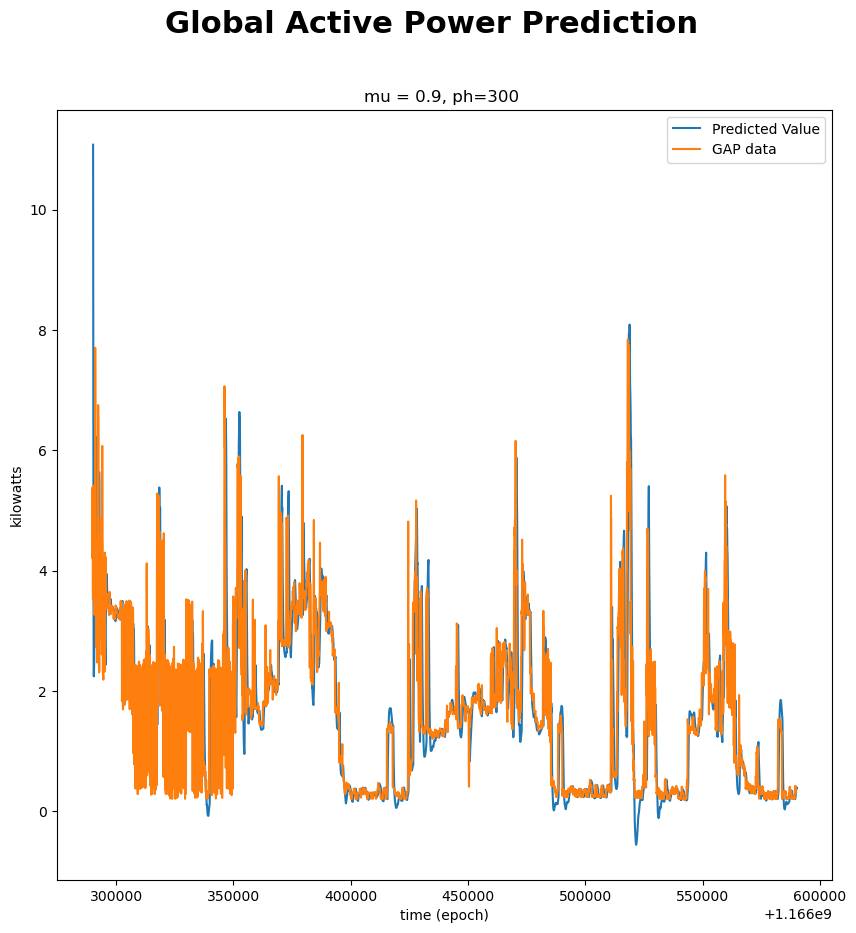

In [7]:
plot_all(tp_pred, yp_pred, mu, ph)

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

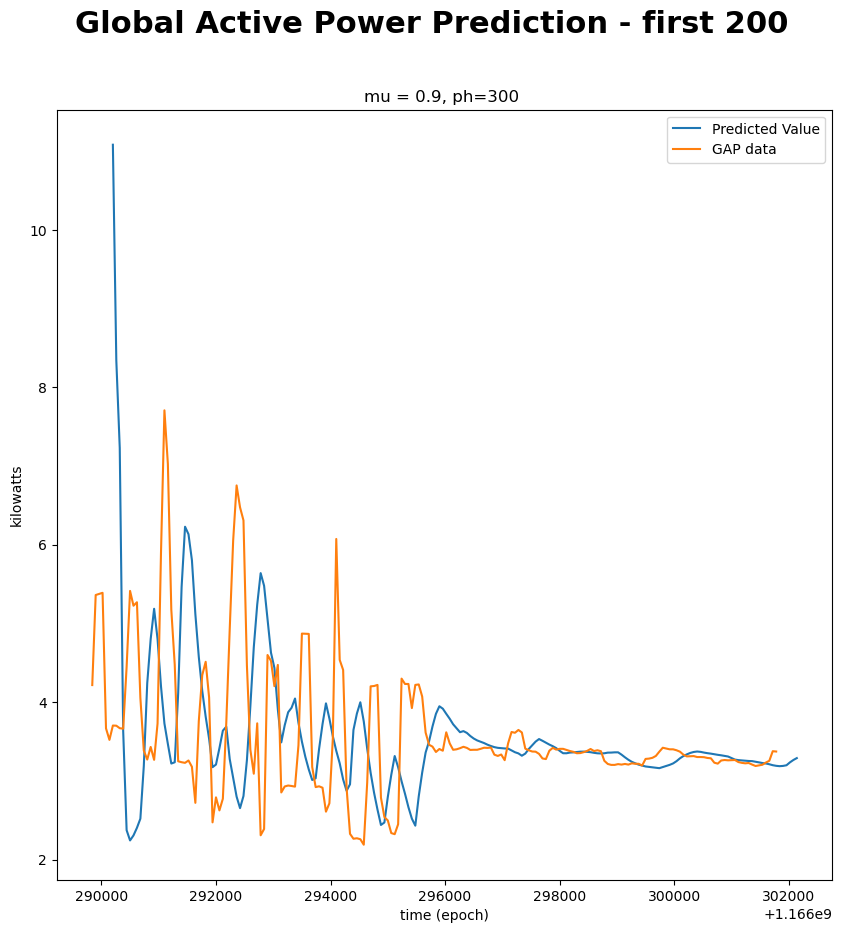

In [8]:
#Plot first 200 data points/predictions
plot_early(tp_pred, yp_pred, mu, ph)

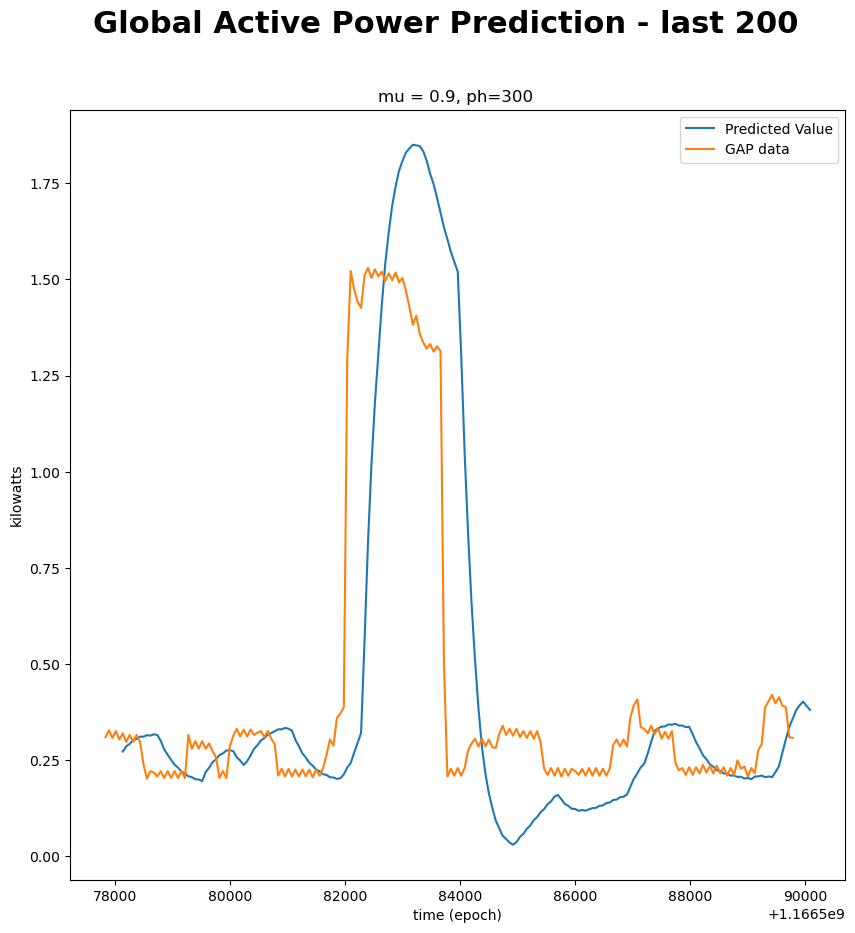

In [9]:
#Plot last 200 data points/predictions
plot_late(tp_pred, yp_pred, mu, ph)

In [10]:
#Calculate MSE of predictions
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.5987740533899373


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: A mean square error of .60 is relatively moderate when considering that we are predicting 5 minutes ahead when each timestamp is in 1 minute intervals. You will notice that the predictions follow the similar trends but there is a decent amount of lag from the prediction versus the actual values. Looking at the differences between the early and late predictions you will notice that the early predictions start extremely off, much higher than the actual value but then slowly starts to normal out to have a similar trend, and the late predictions shows a relatively constant up/down trend with the original data with lag. This shows that earlier predictions might be less reliable than later predictions, but there is still definetly room for improvement. The MSE being relatively moderate means that there is definitely room for improvement but it overall is not terrible. The MSE tells me that there is an average error of .60kw per prediction.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [11]:
#Re-run prediction code for mu = 1
mu = 1

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

tp_pred, yp_pred = create_predictions(ph, mu, n_s)

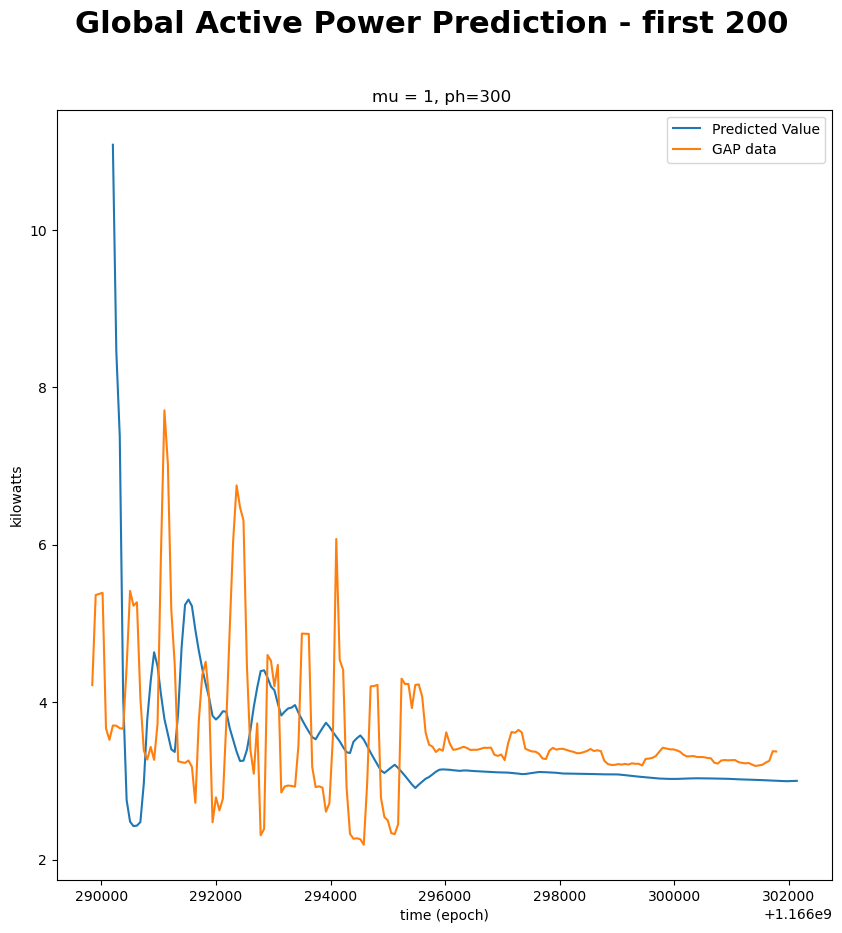

In [12]:
#Plot first 200 data points/predictions for mu = 1
plot_early(tp_pred, yp_pred, mu, ph)

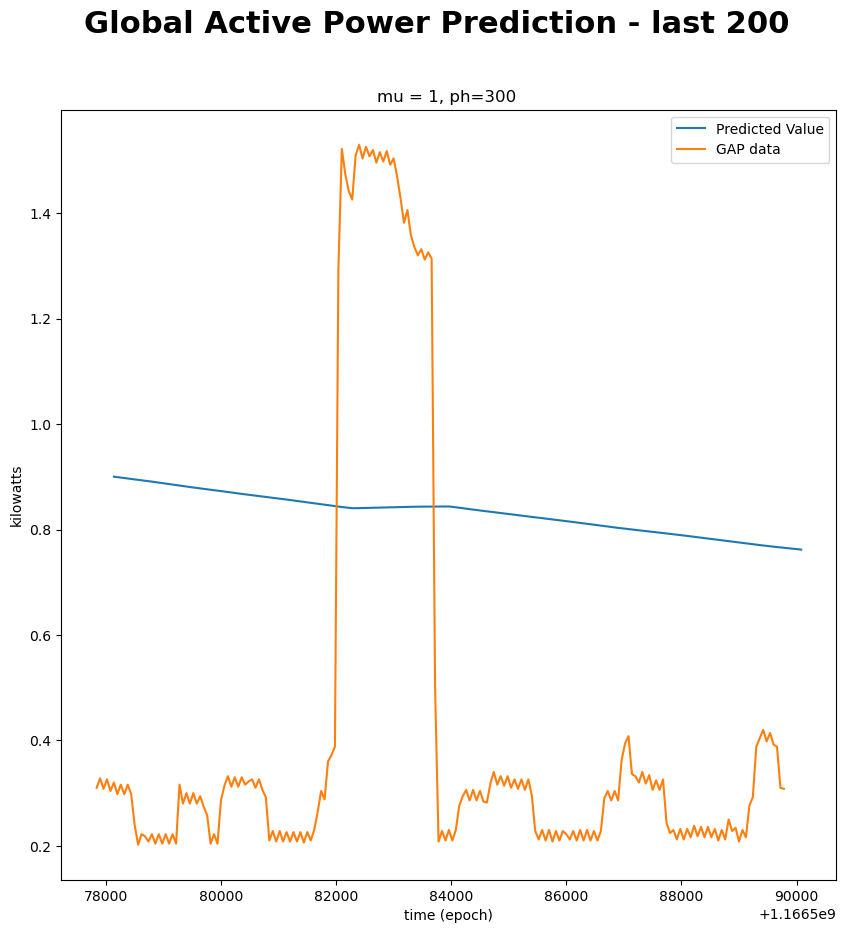

In [13]:
#Plot last 200 data points/predictions for mu = 1
plot_late(tp_pred, yp_pred, mu, ph)

In [14]:
#Calculate MSE of predictions for mu = 1
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 1.4433474819593506


In [15]:
#Re-run prediction code for mu = 0.01
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

tp_pred, yp_pred = create_predictions(ph, mu, n_s)

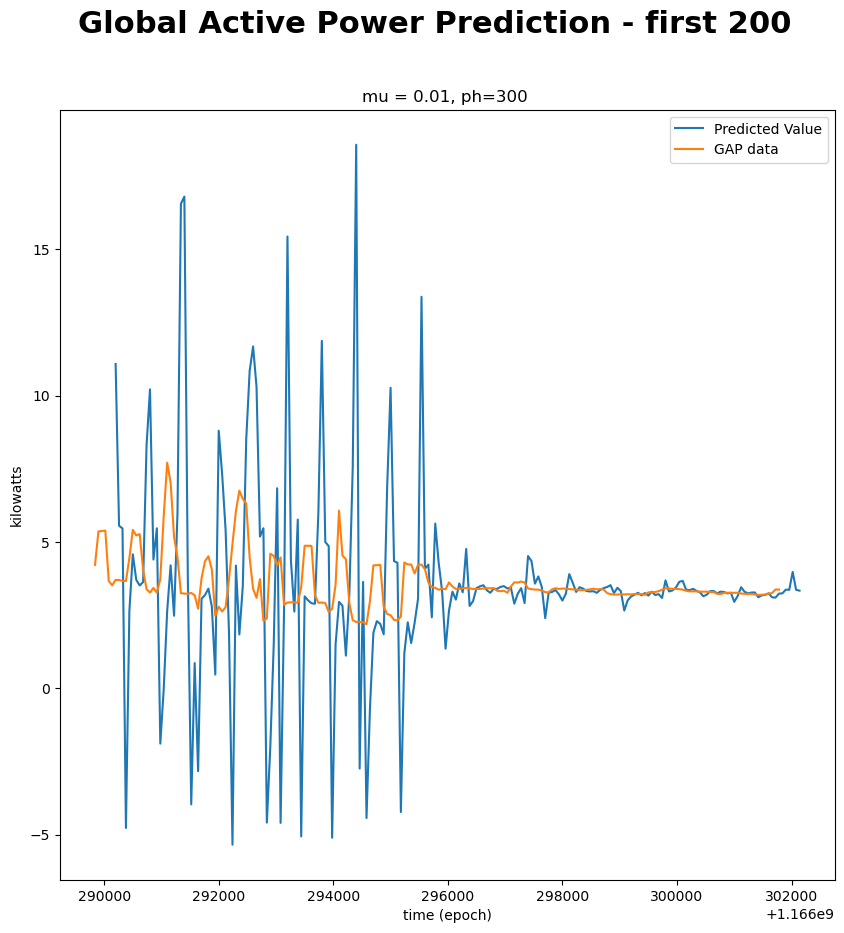

In [16]:
#Plot first 200 data points/predictions for mu = 0.01
plot_early(tp_pred, yp_pred, mu, ph)

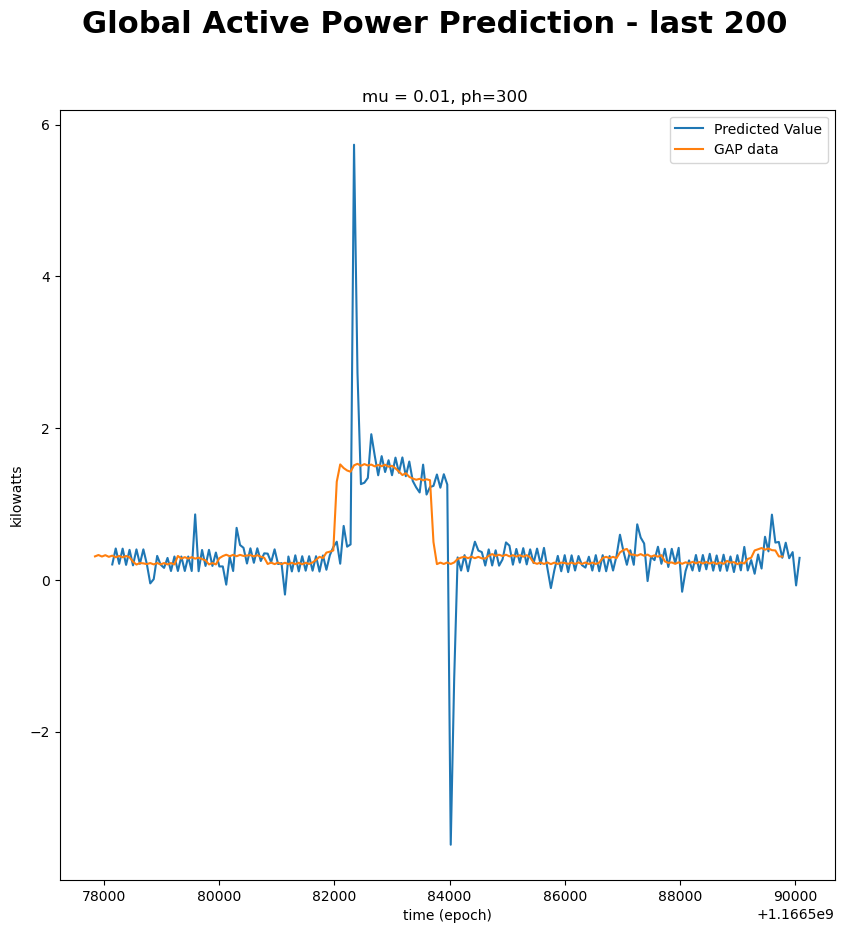

In [17]:
#Plot last 200 data points/predictions for mu = 0.01
plot_late(tp_pred, yp_pred, mu, ph)

In [18]:
#Calculate MSE of predictions for mu = 0.01
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 7.985307094697191


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: I think the mu = 1 model performed pretty poorly, Looking at the charts you will notice that the early predictions ( the first 200 ) start off  extremely chaotic, with the initial extremely high prediction and then large variations within the predictions versus the actual value. The peaks and valleys are much smaller than the actual meaning that the predicted value is usually much less than the actual value that is found, there is also a similar amount of lag to the previous model. The late predictions are not usefull at all and is basically a straight line. This means that the later predictions are all relatively the same, this is not useful for an actual prediction. The MSE tells me that there is an average error of 1.44 kw per prediction. That is relatively high considering the actual range of the values. 

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: I think the mu = 0.01 model initially performed even worse than the mu = 1, the predicted values are way outside of the range of values from the actual values, and even though they get more refined the longer the model runs, the peaks/valleys are still much more chaotic than the actual values. This tells me that the early predictions are extremely unreliable and get slightly more reliable as time goes on. The late predictions show me a prediction trend that is very similar to the actual values reported, however the peaks/valleys are much higher for the predicted values overall. For both the early and late predictions there is a similar amount of lag to the initial model with mu = .9. for the late predictions there are also some large spikes when initially prediction values when is a surge in power usage and when that surge ends. The MSE tells me that there is an average error of 7.99 kw per prediction which is extremely bad, especially when comparing them to the other models. This is the worst overall and means that on average the prediction is very innacurate. 

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: The model with the mu = .9 is the best, I know this because of observing the graphs and the MSE values. The MSE value for .9 was ~.60 which was significantly lower than the 1.4 for mu = 1 and the 7.9 for mu = .01. Just from observing the graphs the difference is obvious where the predicted value trends are much closer to the actual values throughout the models lifetime. This makes sense because a mu of 1 essentially means that there is no decay in the data, which means that the values never lose any weight when comparing them to newer readings, and a mu = .01 means that there is an extremely high decay, meaning that the values quickly lose a lot of value. A high decay is not beneficial because we still want to use some of the previous data to make meaningful decisions, but the decay essentially says that the values quickly become unimportant. 

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: We could likely improve our model by fine tuning the mu value to a value that consistently provides a smaller MSE. While also fine tuning the prediction horizon to try to predict values that are not as far out. This would lower the amount of lag in the prediction and help increase the accuracy. We obviously want to have a decent range of time to predict so 1 minute might not be useful, but there might be a better value between 1 and 5. We can also add support to increase the value of the PH to above 5 minutes, with the caveat that it will be less accurate, but allow users to get an idea of usage beyond that time frame. 

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [19]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame(df[['unix', 'Voltage']])
ys = pd.DataFrame(df.Global_active_power)

ph = 300 #5 minutes
ph_index = 5
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [20]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage
# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    # perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)# times and voltage are x, global active power readings are y
    # Coefficients of the linear model, y = mx + q 
    # store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    
    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1, 0] + ph #next time stamp
    yp = (m_tmp[0][0] * tp) + (m_tmp[0][1] * ts.iloc[i - 1, 1]) + q_tmp #m[0]x[0] + m[1]x[1] + b

    tp_pred[i-2] = tp
    # fetch the individual value so that numpy does not have deprecation warning.
    yp_pred[i-2] = yp[0]

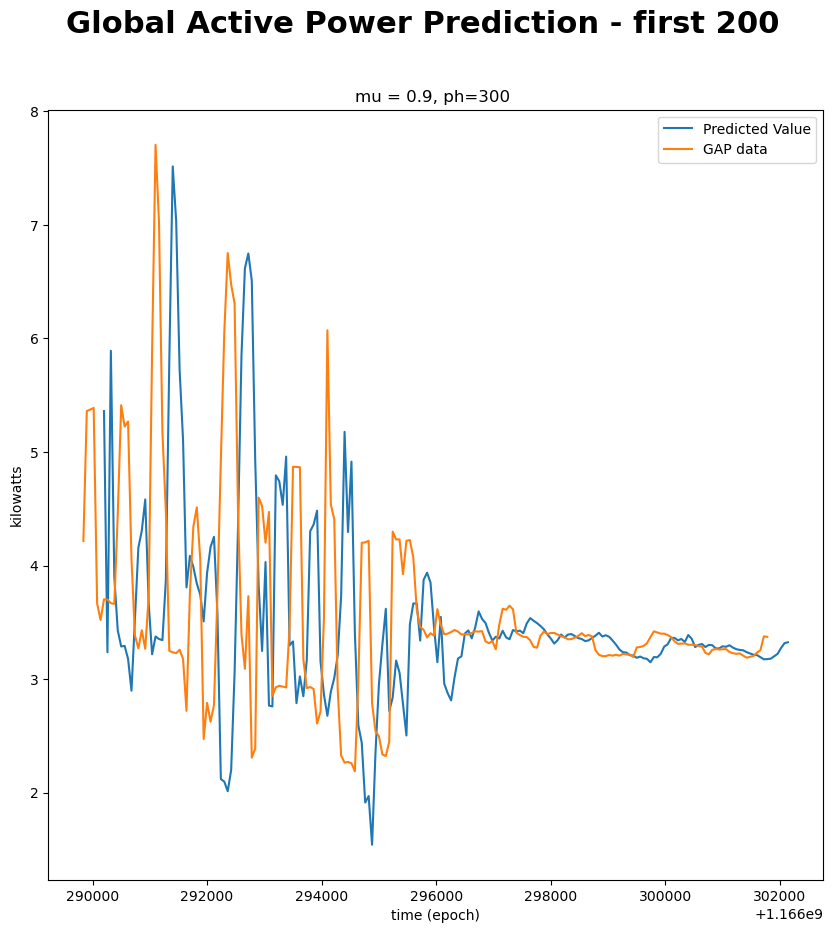

In [21]:
#Plot first 200 data points/predictions for the expanded dataset
plot_early(tp_pred, yp_pred, mu, ph)

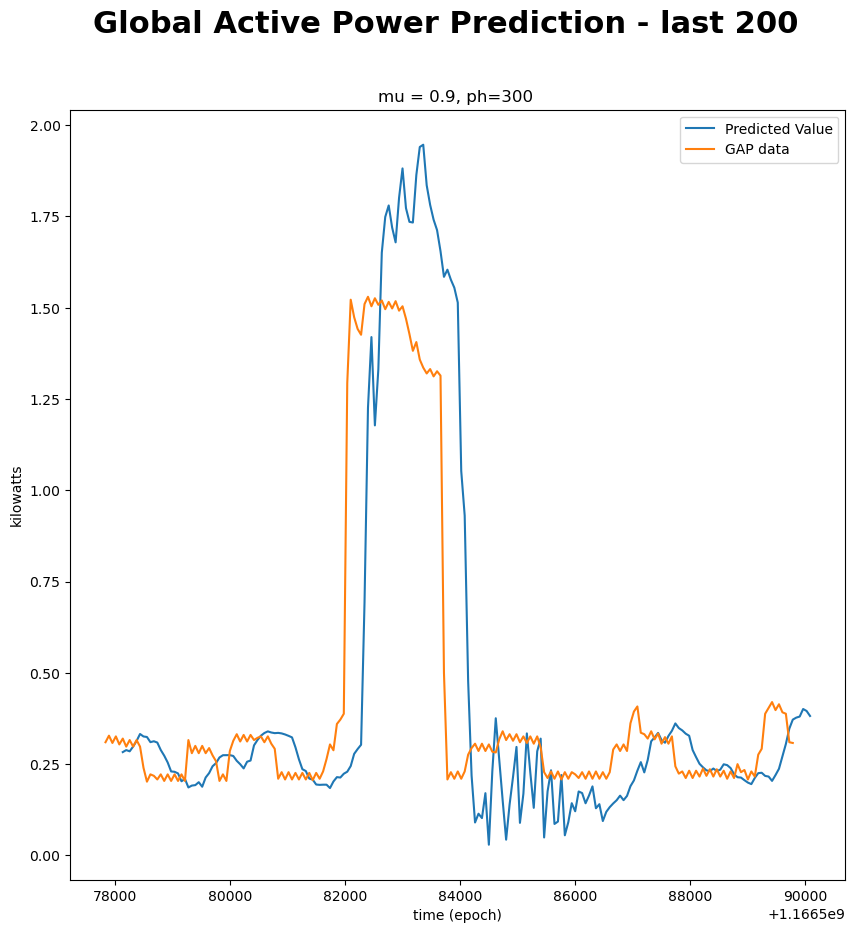

In [22]:
#Plot last 200 data points/predictions for the expanded data
plot_late(tp_pred, yp_pred, mu, ph)

In [23]:
#Calculate MSE of predictions for the expanded data
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.5969934658929079


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: After adding voltage, the model performed very slightly better than without voltage. The early and late graphs are nearly identical to the visualizations for the model without voltage, with the exception of the prediction line for the model with voltage included not being as smooth, with more peaks/valleys. However, I come to the conlcusion about it performing better from the MSE, which is very very slightly lower than the model without voltage. That means that each prediction on average for the model with voltage had was off by very minimally less. 

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: To improve the model, I chose the suggestion of using a moving window to limit predictions instead of the mu factor. I think this might improve the model because, instead of the values decaying and becoming less relevant, it will only consider the recent values. When considering the type of data I am creating a model for, global active power values from household energy consumption data, we really only care about the values that are closer to the time range of the prediction. A value at 1:00am wont really have much bearing on a prediction for 12:00pm. In theory, this model should also be more efficient to run because we do not need to calculate the weight of every value that comes before the predicted time. For a controlled test, I will not be including voltage and will compare the results to the initial model.

In [24]:
#create your alternative training data here
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 300 #5 minutes
ph_index = 5
window = 15 # 15 minutes

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [25]:
#re-run the prediction code here
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    # Get the start of the moving window, either 0 or the current index minus the window size.
    start_index = max(0, i - window)  # Only use the last 'window_size' samples
    ts_tmp = ts.iloc[start_index:i]
    ys_tmp = ys.iloc[start_index:i]
        
    # perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp) # time is x, global active power readings are y
    
    # Coefficients of the linear model, y = mx + q 
    # store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    
    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph #next time stamp
    yp = m_tmp*tp + q_tmp #mx + b

    tp_pred[i-2] = tp
    # fetch the individual value so that numpy does not have deprecation warning.
    yp_pred[i-2] = yp[0][0]

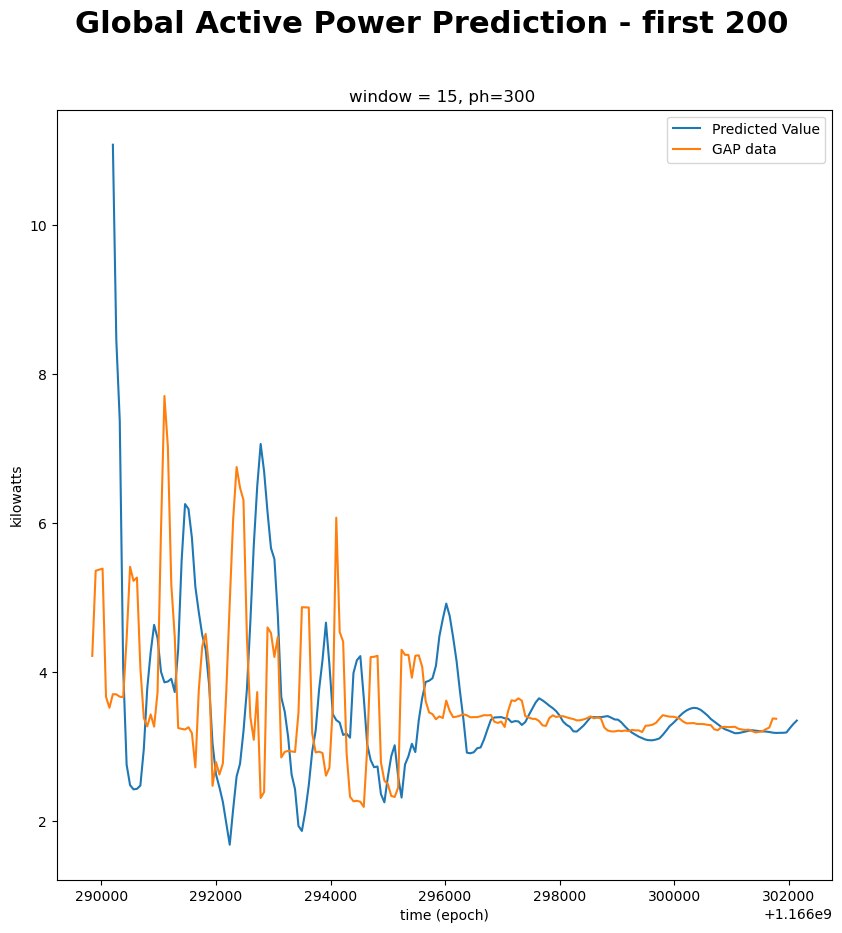

In [26]:
#Plot first 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction - first 200', fontsize=22, fontweight='bold')
ax.set_title('window = %g, ph=%g ' %(window, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

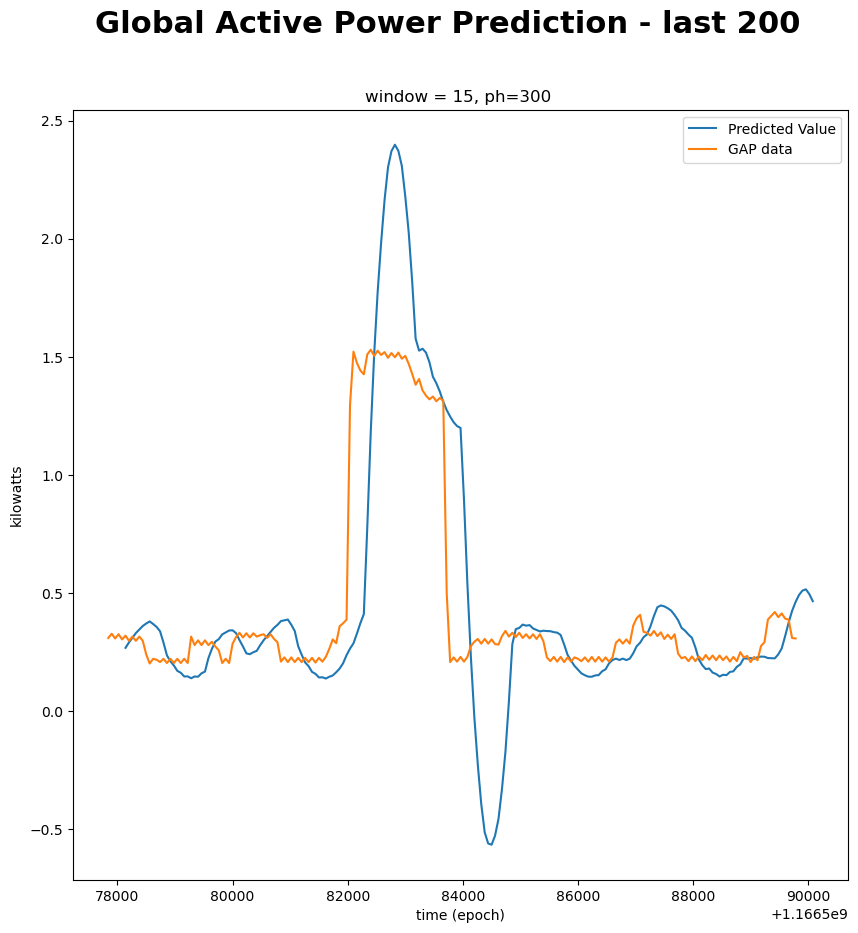

In [27]:
#Plot last 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction - last 200', fontsize=22, fontweight='bold')
ax.set_title('window = %g, ph=%g ' %(window, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [28]:
#Calculate MSE of predictions for alternative model
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.7613126486439663


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: I believe that my alternative model, in certain scenarios, performed better than the original model, and worse in others. The early graph shows that using a moving window of 15 minutes, we actually initially start off with pretty decent results. The predictions are very close, albeit with some lag, to the actual values, however there were less spikes predited. Looking at the later graph, you can see that the relatively small spikes were predicted well, and infact, I believe that the predictions for the average sized spikes performed better than the original model with the mu = .9 and no window. However you can clearly see that the predictions became increasingly unreliable for very large spikes in energy consumption. The predictions shot way past what the actual values were, until it normalized at the "average" usage spike levels. Looking at the overall MSE, comparing it to the original model shows that the alternative model performed worse, at .761 MSE, meaning on average (when compared to the original model) the alternative model had an additional error of 0.761 - 0.599 = 0.162 kw per prediction. The higher average is most likely due to the higher values in the predictions for larger spikes of energy usage. So when predicting large spikes of energy consumption the alternative model performed worse, whereas the original model performed worse when predicting values for the average spikes of energy consumption. The original model was also much more inconsistent at predicting the average sized spikes compared to the alternative model. 

To improve the model, I could employ strategies to include mu decay, while also increasing the window size. We can also lower the prediction horizon to improve the accuracy of predictions. Another strategy to improve the model could be to employ a combination of the moving window method, the forgetting factor, and implement strategies to utilize prediction values for similar times of day and days of the week.

It's worth noting that the results we're getting in this assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.

In [29]:
# Combining the forgetting factor, moving window, and voltage variable strategies
ts = pd.DataFrame(df[['unix', 'Voltage']])
ys = pd.DataFrame(df.Global_active_power)

ph = 300 #5 minutes
ph_index = 5
mu = .9
window = 240 # 4 hours

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

#re-run the prediction code here
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    # Get the start of the moving window, either 0 or the current index minus the window size.
    start_index = max(0, i - window)  # Only use the last 'window_size' samples
    ts_tmp = ts.iloc[start_index:i]
    ys_tmp = ys.iloc[start_index:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    # perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights) # time is x, global active power readings are y
    
    # Coefficients of the linear model, y = mx + q 
    # store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    
    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph #next time stamp
    yp = (m_tmp[0][0] * tp) + (m_tmp[0][1] * ts.iloc[i - 1, 1]) + q_tmp #m[0]x[0] + m[1]x[1] + b

    tp_pred[i-2] = tp
    # fetch the individual value so that numpy does not have deprecation warning.
    yp_pred[i-2] = yp[0]

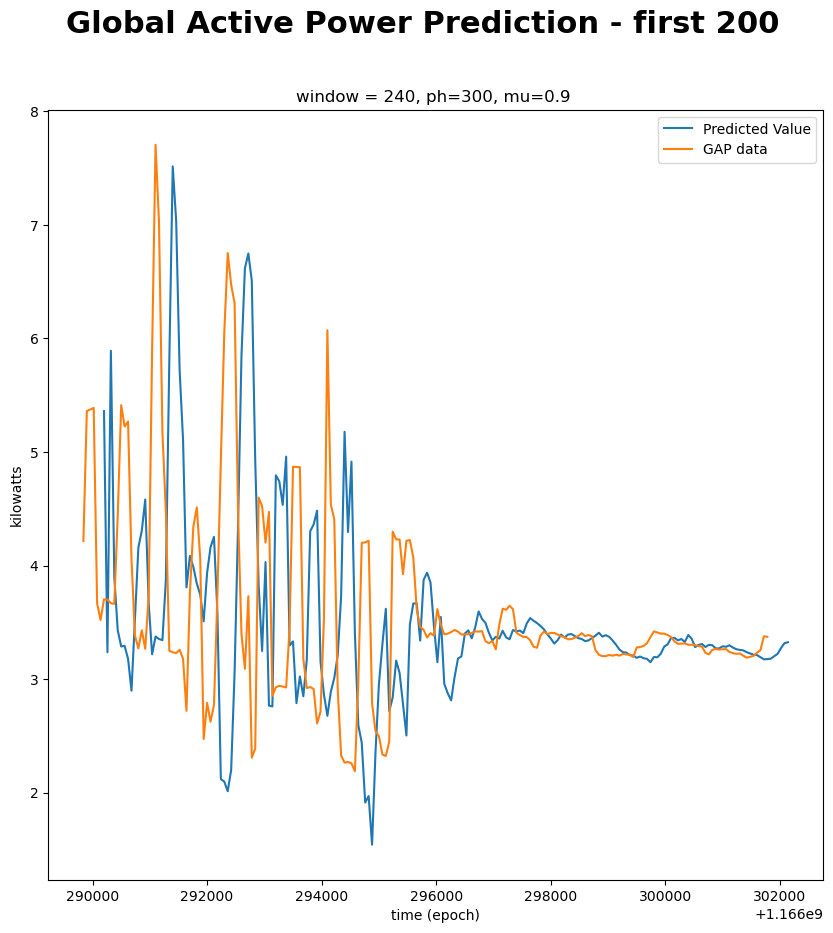

In [30]:
#Plot first 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction - first 200', fontsize=22, fontweight='bold')
ax.set_title('window = %g, ph=%g, mu=%g ' %(window, ph, mu))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

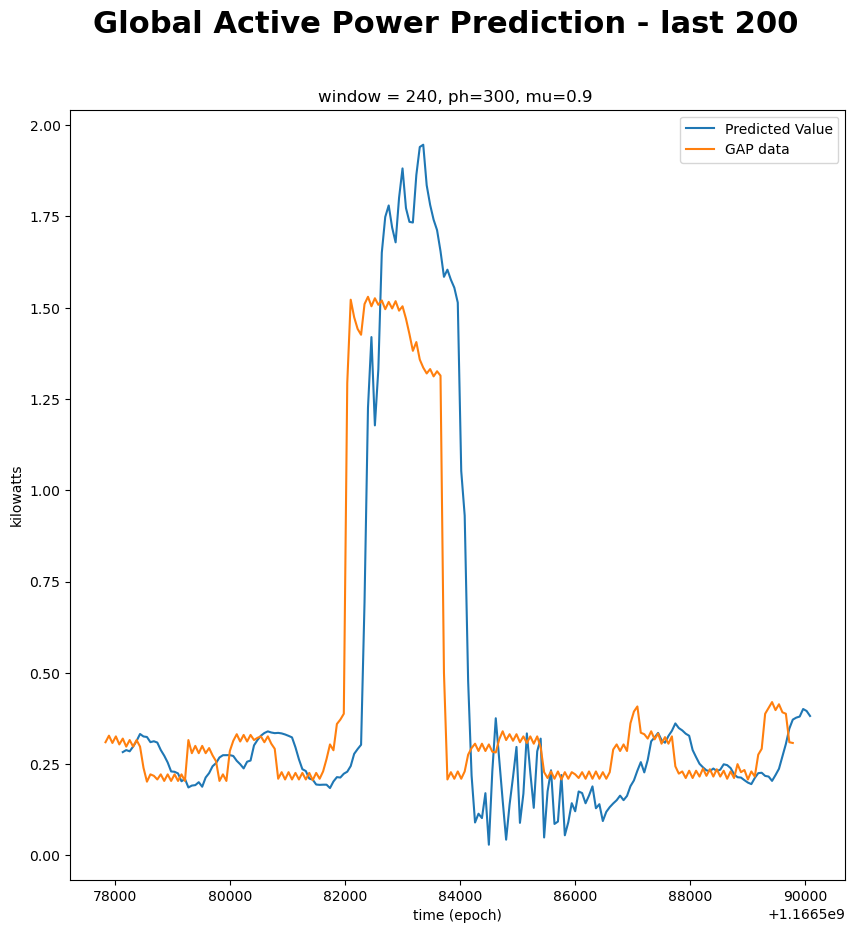

In [31]:
#Plot first 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction - last 200', fontsize=22, fontweight='bold')
ax.set_title('window = %g, ph=%g, mu=%g ' %(window, ph, mu))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [32]:
#Calculate MSE of predictions for alternative model
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.5969934665970414


Combining all three practiced methods increases the performance of the model very slightly. Looking at the Early graph, you will notice that the predictions are consistently closer to the actual values when compared to the original model, and the late graph shows that the extreme values are predicted slightly better as well. between both graphs, the average spikes are more consistent with the exception of a short period of time after massive energy usage spikes. The MSE is also very slightly smaller than the originals, meaning on average, this model performs very slightly better. 